In [ ]:
"""
 - data from https://www.kaggle.com/c/indoor-location-navigation
 - data conversion using main_interp_wtime.py based on time of the wifi recordings 
 - these area every 2.2-2.5 seconds, and their position is intyerpolated linearily assuming constant speed between waypoints 
 - BLE beacons are attached to the closes interpolated point 
 - actual waypoint in the data ay not appear in the json produced
"""

indoor_comp_import.png - example of resulted points (blue) 


In [98]:
from utils import *
import sys, os, random
# from compare_locations import compare_locations

datadir = "../indoor-location-competition-20/"
#datadir = "../data/nowl/"
# preprocessed already, with 


In [123]:
etaje_fnames = [
"F1.intw.json"]

etaje = []
for e in etaje_fnames: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    etaje.append(etaj)


In [188]:
import numpy as np
from scipy.spatial.distance import braycurtis
from scipy.stats import ks_2samp, chisquare
import copy 

def merge_wifi_fingerprints(flist):
    fingerprint = copy.deepcopy(flist[0])
    for f2 in copy.deepcopy(flist[1:]):
        if not "wifi" in f2.keys():
            continue
        for mac in f2["wifi"].keys():
            if not mac in fingerprint["wifi"].keys():
                fingerprint["wifi"][mac] = f2["wifi"][mac]
                #fingerprint["wifi"][mac]['rssi'] = []
            else:
                fingerprint["wifi"][mac]['rssi'].extend(f2["wifi"][mac]['rssi'])
            fingerprint["wifi"][mac]['rssi'].sort()    
    return fingerprint


def compare_locations(c1, c2, simil_method = braycurtis,  selection = 'Average'):
    rssi1 = []
    rssi2 = []
    w = [] #weight for braycurtis
    
    # take the first fingerprint in the list 
    #wifi1 = c1['fingerprints'][0]['wifi']
    #wifi2 = c2['fingerprints'][0]['wifi']

    # take a random fingerprint in the list 
    #wifi1 = c1['fingerprints'][random.randint(0,3)]['wifi']
    #wifi2 = c2['fingerprints'][random.randint(0,3)]['wifi']

    #merge all existing fingerprints for each collection
    wifi1 = merge_wifi_fingerprints(c1['fingerprints'])['wifi']
    wifi2 = merge_wifi_fingerprints(c2['fingerprints'])['wifi']
    
    common_aps = list(set(wifi1.keys()) & set(wifi2.keys()))
    
    aps_only1 = list(set(wifi1.keys()).difference(set(wifi2.keys())))
    aps_only2 = list(set(wifi2.keys()).difference(set(wifi1.keys())))
    
    # how power is used in comparison 
    
    p1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), wifi1.keys())))
    p2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), wifi2.keys())))
    pc1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), common_aps)))
    pc2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), common_aps)))
    po1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), aps_only1)))
    po2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), aps_only2)))
    
    """
    print(f"common aps={len(common_aps)}")
    print(f"1={len(aps_only1)} 2={len(aps_only2)}")
      
    print(f"p1={np.mean(p1)} p2={np.mean(p2)}")
    print(f"pc1={np.mean(pc1)} pc2={np.mean(pc2)}")
    print(f"po1={np.mean(po1)} po2={np.mean(po2)}")
    #"""
        
    # No APs in common -> similarity = 1
    if not common_aps:
        return 1

    # If not enough common APs -> similarity = 1
    if (po1 + 1.0 > pc1 and len(common_aps)*2  < len(aps_only1)) or \
        (po2 + 1.0 > pc2 and len(common_aps)*2 < len(aps_only2)) or \
            len(common_aps) < 4:
        return 1

    for ap in common_aps:
        
        if selection == 'Bestdir':
            for f1 in c1['fingerprints']: # all fingerprint dirs in the query 
                if not ap in f1['wifi'].keys():
                    continue
                m1 = np.average(f1['wifi'][ap]['rssi'])
                best = 100                
                for f2 in c2['fingerprints']: 
                    if not ap in f2['wifi'].keys():
                        continue
                    m2 = np.average(f2['wifi'][ap]['rssi'])
                    if(math.fabs(m2-m1)) < best:  # find one dir with closest RSSI
                        best = math.fabs(m2-m1)
                        bestf = m2
                rssi1.append(m1)
                rssi2.append(bestf)
                
        # Take only the first RSSI value                
        if selection == 'First':
            rssi1.append(wifi1[ap]['rssi'][0])
            rssi2.append(wifi2[ap]['rssi'][0])

        # Make an average of all RSSI values
        if selection == 'Average':
            #rssi1.append(np.average(adjust_rssi(wifi1[ap]['rssi'])))
            #rssi2.append(np.average(adjust_rssi(wifi2[ap]['rssi'])))
            rssi1.append(np.average(wifi1[ap]['rssi']))
            rssi2.append(np.average(wifi2[ap]['rssi']))

            w.append(min(len(wifi1[ap]['rssi']), len(wifi2[ap]['rssi'])))

        if selection == 'Median':
            rssi1.append(np.median(wifi1[ap]['rssi']))
            rssi2.append(np.median(wifi2[ap]['rssi']))

        if selection == 'Mean':
            rssi1.append(np.mean(wifi1[ap]['rssi']))
            rssi2.append(np.mean(wifi2[ap]['rssi']))

        if selection == 'Std':
            rssi1.append(np.std(wifi1[ap]['rssi']))
            rssi2.append(np.std(wifi2[ap]['rssi']))

        if selection == 'Max':
            rssi1.append(np.max(wifi1[ap]['rssi']))
            rssi2.append(np.max(wifi2[ap]['rssi']))
            
        if selection == 'KS':
            _, p = ks_2samp(wifi1[ap]['rssi'], wifi2[ap]['rssi'])
            rssi1.append(p)
            rssi2.append(1.0)

        if selection == 'Tempered':
            rss_1.append(np.average(rssi_v[index][key]) * random.uniform(0.8, 1.2))
            rss_2.append(np.average(rssi_v[r][key]) * random.uniform(0.8, 1.2))

    #print(f"1={rssi1}\n2={rssi2}\ncommon={common_aps}")
    if selection != 'KS':
        mdif = np.mean(np.array(rssi2)-np.array(rssi1))
        
    rssi2 = np.array(rssi2) #- mdif
    rssi1 = np.array(rssi1)
    
    #print(f"len1={len(rssi1)}rssi1={rssi1}\nlen2={len(rssi2)}rssi2={rssi2}")  
    #print(f"c1 ={c1['x'], c1['y']}  c2={c2['x'], c2['y']}")
    #print(f"mean1={np.mean(rssi1)}median1={np.median(rssi1)}\nmean2={np.mean(rssi2)}median2={np.median(rssi2)}")    
    
    return simil_method(adjust_rssi(rssi1), adjust_rssi(rssi2))


In [214]:
# test all points on a floor versus randomly chosen points, retain only ones under 20m
# results ~ 8000 points 
before = datetime.datetime.now()
e = 0
npct = len(etaje[e])
bd = []
ks = np.array([])
avg = np.array([])
md = np.array([])
r = np.arange(0, npct)
for point in r: 
    ra = np.random.choice(range(0,npct), size=50, replace=True)
    for p in ra:
        if p == point: 
            continue 
        eu_dist = euclidean([etaje[e][point]['x'], etaje[e][point]['y'], etaje[e][point]['z']], 
                                [etaje[e][p]['x'], etaje[e][p]['y'], etaje[e][p]['z']]) 
        if eu_dist < 20.0: 
            bd.append([ point, p, eu_dist, 
                compare_locations(etaje[e][point], etaje[e][p], selection = 'Average')])
        """"
        ks = np.append(ks, [point, p, eu_dist, 
                compare_locations(etaje[e][point], etaje[e][p], selection = 'KS')])
        avg = np.append(avg, [point, p, eu_dist, 
                compare_locations(etaje[e][point], etaje[e][p], selection = 'Average')])
        md = np.append(md, [point, p, eu_dist, 
                compare_locations(etaje[e][point], etaje[e][p], selection = 'Median')])
        """
after = datetime.datetime.now()
print(f"{len(bd)} pairs in {(after-before).seconds} seconds")

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


7977 pairs in 201 seconds


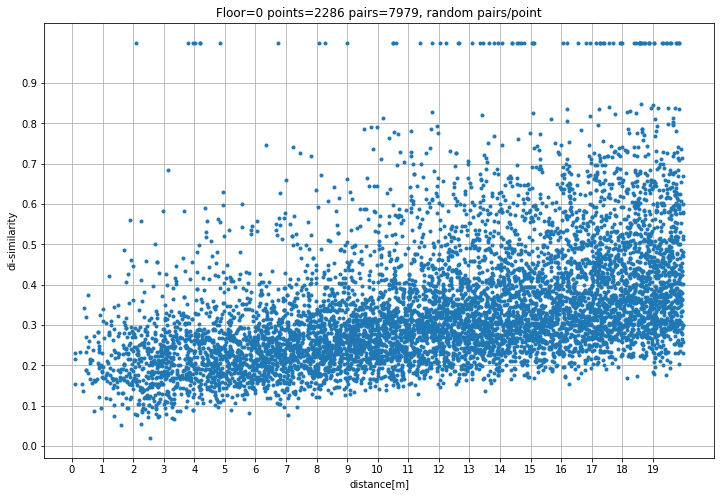

In [209]:
fig =  plt.figure(figsize=(12, 8))        
plt.plot([r[2] for r in bd] , [r[3] for r in bd], ".", label='bestdir')
   
plt.xlabel('distance[m]')
plt.ylabel('di-similarity')
plt.grid(True)
plt.title(f"Floor={e} points={npct} pairs={len(bd)}, random pairs/point")
plt.xticks(range(0, 20))
plt.yticks(np.arange(0, 1, 0.1))
#plt.legend(loc="upper right",shadow=True, fancybox=True)
plt.show()
#fig.savefig(f"Braycurtis_vs_dist_floor{len(etaje)}_8000pts.pdf", bbox_inches='tight')

In [212]:
#print("75-50 ", compare_locations(etaje[e][1750], etaje[e][1752], selection = 'Average'))

for r in bd:
    if r[2] <  4.0 and r[3] < 0.05:
        print(r[0], "--", r[1], "<", 
              compare_locations(etaje[e][r[0]], etaje[e][r[1]], selection = 'Average'), \
              compare_locations(etaje[e][r[1]], etaje[e][r[0]], selection = 'Average'), \
              ">", r[2], r[3])
        

1936 -- 1935 < 0.019636230972208672 0.019636230972208672 > 2.5617445257911227 0.019636230972208672
